In [16]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

csv_path = 'TorqueData_noFriction_NL_NG.xlsx'

torqueData = pd.read_excel(csv_path)

torque = torqueData['Torque']

def torque_to_X_y(torqueData, window_size = 5):
    torque_as_np = torqueData.to_numpy()
    X = []
    y = []
    for i in range(len(torque_as_np)-window_size):
        row = [[a] for a in torque_as_np[i:i+5]]
        X.append(row)
        label = torque_as_np[i+5]
        y.append(label)
    return np.array(X),np.array(y)

In [17]:
WINDOW_SIZE = 5
X,y = torque_to_X_y(torque,WINDOW_SIZE)

X_train, y_train = X[:1300], y[:1300]
X_val, y_val = X[1300:1600], y[1300:1600]
X_test, y_test = X[1600:2300], y[1600:2300]

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5,1)))
model1.add(LSTM(64))
model1.add(Dense(8,'relu'))
model1.add(Dense(1,'linear'))
model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
cp = ModelCheckpoint('model1.keras',save_best_only=True)
model1.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.0001),metrics=[RootMeanSquaredError()])
model1.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=1000,callbacks=[cp])

Epoch 1/1000
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.5283e-09 - root_mean_squared_error: 6.7165e-05 - val_loss: 3.7411e-09 - val_root_mean_squared_error: 6.1165e-05
Epoch 2/1000
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5604e-09 - root_mean_squared_error: 5.9627e-05 - val_loss: 4.3210e-09 - val_root_mean_squared_error: 6.5734e-05
Epoch 3/1000
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7022e-09 - root_mean_squared_error: 6.0804e-05 - val_loss: 3.9329e-09 - val_root_mean_squared_error: 6.2713e-05
Epoch 4/1000
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9461e-09 - root_mean_squared_error: 6.2751e-05 - val_loss: 3.5087e-09 - val_root_mean_squared_error: 5.9234e-05
Epoch 5/1000
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7348e-09 - root_mean_squared_error: 6.0924e-05 - val_loss: 3.8125e-09 - val_root_mean_squared_error: 6.1745e-05
Epoch 6/1000
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7646e-09 - root_mean_squared_error: 6.1235e-05 - val_loss: 3.5568e-0

In [25]:
from tensorflow.keras.models import load_model
model1 = load_model('model1.keras')

In [26]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions,'Actuals':y_train})
train_results

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


,Train Predictions,Actuals
0,0.000005,0.000000
1,0.000005,0.000000
2,0.000005,0.000000
3,0.000005,0.000000
4,0.000005,0.000000
...,...,...
1295,0.000005,0.000000
1296,0.000005,-0.000083
1297,0.000005,0.000083
1298,0.000005,0.000000


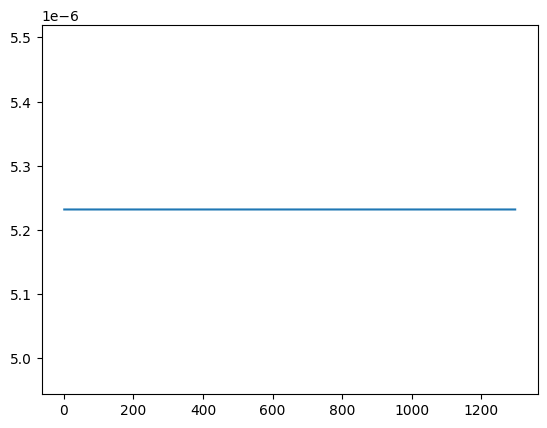

In [29]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][1:1299])
#plt.plot(train_results['Actuals'][1:1299])